In [2]:
import sys, os

# sys path hack to allow importing the encoding functions
sys.path.insert(0, os.path.abspath('../encoding'))

In [5]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# DETR - Object Detection

In [16]:
import json 

with open('../data/sceneGraphs/train_sceneGraphs.json') as f:
    scene_graphs = json.load(f)

In [9]:
from transformers import DetrForObjectDetection
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to("mps")

# CLIP - Classification

In [3]:
from transformers import CLIPProcessor, CLIPImageProcessor, CLIPTokenizer, TFCLIPModel

model = TFCLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-large-patch14")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

/Users/jan/Git/tuw-master-thesis/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-03-05 21:59:49.647520: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-05 21:59:49.647545: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
All model checkpoint layers were used when initializing TFCLIPModel.

All the layers of TFCLIPModel were initialized from the model checkpoint at openai/clip-vit-large-patch14.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCLIPModel for predictions without further training.


tf.Tensor([-0.26917768 -0.2530048  -0.12887064], shape=(3,), dtype=float32)
tf.Tensor([[26.917759 25.30047  12.887063]], shape=(1, 3), dtype=float32)


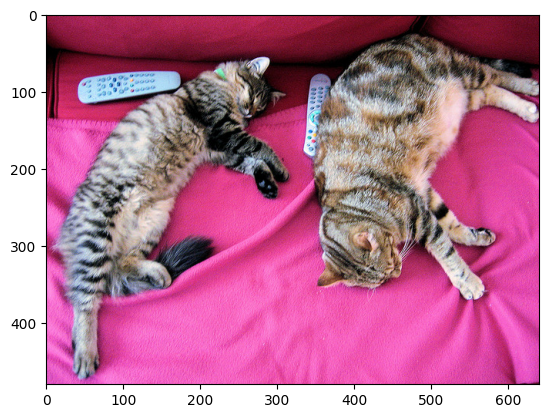

In [6]:
from PIL import Image
import requests
import tensorflow as tf
import matplotlib.pyplot as plt

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

plt.imshow(image)

inputs = processor(text=["two cats lying on a couch", "two cats and two remotes", "two dolphins in the water"], images=image, return_tensors="tf", padding=True)

cosine_similarity = tf.keras.losses.CosineSimilarity(reduction=tf.keras.losses.Reduction.NONE)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
print(cosine_similarity(outputs.text_embeds, outputs.image_embeds))
print(logits_per_image)

In [9]:
import json 

with open('../data/metadata/gqa_all_attribute.json') as f:
    all_attributes = json.load(f)

def sanitize(name):
    # source: DFOL-VQA
    plurale_tantum = ['this', 'yes', 'pants', 'shorts', 'glasses', 'scissors', 'panties', 'trousers', 'binoculars', 'pliers', 'tongs',\
        'tweezers', 'forceps', 'goggles', 'jeans', 'tights', 'leggings', 'chaps', 'boxers', 'indoors', 'outdoors', 'bus', 'octapus', 'waitress',\
        'pasta', 'pita', 'glass', 'asparagus', 'hummus', 'dress', 'cafeteria', 'grass', 'class']

    irregulars = {'shelves': 'shelf', 'bookshelves': 'bookshelf', 'olives': 'olive', 'brownies': 'brownie', 'cookies': 'cookie'}
    
    temp = name.strip().lower()
    if temp in irregulars:
        temp = irregulars[temp]
    elif not (temp.split(' ')[-1] in plurale_tantum or temp[-2:] == 'ss'):
        temp = temp

    return temp

def extract_attributes(question):
    attributes = set()
    for operation in question['semantic']:
        if operation['operation'] == 'relate':
            relation_type = operation['argument'].split(',')[1]
            if relation_type.startswith('same '):
                attributes.add(relation_type[5:])
        elif operation['operation'] == 'query':
            attributes.add(operation['argument'])
        elif operation['operation'] == 'common':
            attributes.update(all_attributes.keys())
        elif (operation['operation'] == 'same' or operation['operation'] == 'different') and operation['argument']!= 'type':
            attributes.add(operation['argument'])
        elif operation['operation'].startswith('filter') or operation['operation'].startswith('verify') or operation['operation'].startswith('same') or operation['operation'].startswith('different'):
            attributes.add(' '.join(operation['operation'].split(' ')[1:]))
        elif operation['operation'].startswith('choose') and operation['argument'] != '':
            attributes.add(' '.join(operation['operation'].split(' ')[1:]))
        
    return {sanitize(a) for a in attributes}

def extract_classes(question):
    classes = set()
    for operation in question['semantic']:
        if operation['operation'] == 'select':
            classes.add(operation['argument'].split('(')[0])
        elif operation['operation'] == 'relate':
            target_class = operation['argument'].split(',')[0]
            if target_class != '_':
                classes.add(target_class)
        elif operation['operation'] == 'choose rel':
            classes.add(operation['argument'].split(',')[0])
        elif operation['operation'] == 'verify rel':
            classes.add(operation['argument'].split(',')[0])
    return {sanitize(c) for c in classes}

def extract_relations(question):
    relations = set()
    for operation in question['semantic']:
        if operation['operation'] == 'relate':
            relation = operation['argument'].split(',')[1]
            if not relation.startswith('same '):
                relations.add(relation)
        elif operation['operation'] == 'choose rel':
            relations.add(operation['argument'].split(',')[1].split('|')[0])
            relations.add(operation['argument'].split(',')[1].split('|')[1])
        elif operation['operation'] == 'verify rel':
            relations.add(operation['argument'].split(',')[1])
    return {sanitize(r) for r in relations}
        

Who is wearing a shirt? -> man
select: shirt (1282189)->relate: person,wearing,s (1282164) [0]->query: name [1]


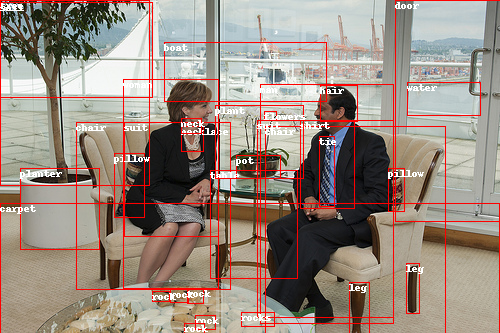

In [10]:
from PIL import Image, ImageDraw

with open("../data/questions/train_sampled_questions_2000.json") as f:
   questions = list(json.load(f).values())

question = questions[1]
print(f"{question['question']} -> {question['answer']}")
print(question['semanticStr'])
image = Image.open(f"../data/images/{question['imageId']}.jpg")

draw = ImageDraw.Draw(image)

for object in question['sceneGraph']['objects'].values():
   object_crop = image.crop((object['x'], object['y'], object['x']+object['w'], object['y']+object['h']))
   draw.rectangle((object['x'], object['y'], object['x']+object['w'], object['y']+object['h']), outline="red", width=1)
   draw.text((object['x'], object['y']), object["name"], fill="white")

image

In [30]:
print(question['semanticStr'])
print(extract_attributes(question))
print(extract_classes(question))
print(extract_relations(question))

select: shirt (1282189)->relate: person,wearing,s (1282164) [0]->query: name [1]
{'name'}
{'person', 'shirt'}
{'wearing'}


In [12]:
img_width = question['sceneGraph']['width'] - 1
img_height = question['sceneGraph']['height'] - 1

tf_image = tf.io.decode_jpeg(tf.io.read_file(f"../data/images/{question['imageId']}.jpg"), channels=3)

bboxes = tf.convert_to_tensor([
    [object['y']/img_height, object['x']/img_width, (object['y']+object['h'])/img_height, (object['x']+object['w'])/img_width] for object in question['sceneGraph']['objects'].values()
])
box_indices = tf.constant(0, shape=(len(question['sceneGraph']['objects']),))

object_crops = tf.cast(tf.image.crop_and_resize(tf.expand_dims(tf_image, axis=0), bboxes, box_indices, (224,224)), dtype=tf.uint8)

image_inputs = image_processor(tf.unstack(object_crops), return_tensors="tf", do_resize=False, do_center_crop=False)

In [13]:
attribute_values = all_attributes['color']
text_prompts = [
    f"a {val} object" for attr in ['color', 'material'] for val in all_attributes[attr]
]
text_inputs = tokenizer(text=text_prompts, return_tensors="tf", padding=True)

In [14]:
outputs = model(**image_inputs, **text_inputs)

In [32]:
scene_encoding = ""

for oid, object in question['sceneGraph']['objects'].items():
    scene_encoding += f"object({oid})."
    object_crop = image.crop((object['x'], object['y'], object['x']+object['w'], object['y']+object['h']))
    
    for attribute in extract_attributes(question):
        if(attribute == 'name'):
            scene_encoding += f":~ has_attribute({oid}, name, {object['name']}). [0]\n"
        else:
            attribute_values = all_attributes[attribute]
            text_prompts = [f"a {val} object" for val in attribute_values]

            inputs = processor(text=text_prompts, images=object_crop, return_tensors="tf", padding=True)

            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image
            
            for value, logit in zip(attribute_values, logits_per_image[0,:].numpy().tolist()):
                scene_encoding += f":~ has_attribute({oid}, {attribute.replace(' ', '_')}, {value.replace(' ', '_')}). [{-round(1000*logit)}]\n"
    for clazz in extract_classes(question):
        inputs = processor(text=[f"a {clazz}"], images=object_crop, return_tensors="tf", padding=True)

        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        scene_encoding += f":~ has_attribute({oid}, class, {clazz.replace(' ', '_')}). [{-round(1000*logits_per_image.numpy()[0,0])}]\n"
            
    for relation in extract_relations(question):
        for oid2, object2 in question['sceneGraph']['objects'].items():
            if oid2 != oid:
                joined_bbox = (
                    min(object['x'], object2['x']),
                    min(object['y'], object2['y']),
                    max(object['x'] + object['w'], object2['x'] + object2['w']),
                    max(object['y'] + object['h'], object2['y'] + object2['h'])
                )
                joined_crop = image.crop(joined_bbox)
                inputs = processor(text=[f"a {object['name']} {relation} a {object2['name']}"], images=joined_crop, return_tensors="tf", padding=True)

                outputs = model(**inputs)
                logits_per_image = outputs.logits_per_image
                scene_encoding += f":~ has_relation({oid}, {relation.replace(' ', '_')}, {oid2}). [{-round(1000*logits_per_image.numpy()[0,0])}]\n"

print(scene_encoding)

object(1282169).:~ has_attribute(1282169, name, rock). [0]
:~ has_attribute(1282169, class, person). [-18564]
:~ has_attribute(1282169, class, shirt). [-14487]
:~ has_relation(1282169, wearing, 1282168). [-15832]
:~ has_relation(1282169, wearing, 1282165). [-9299]
:~ has_relation(1282169, wearing, 1282164). [-11181]
:~ has_relation(1282169, wearing, 1282166). [-2392]
:~ has_relation(1282169, wearing, 1282161). [-16175]
:~ has_relation(1282169, wearing, 1282160). [-16192]
:~ has_relation(1282169, wearing, 1282163). [-5667]
:~ has_relation(1282169, wearing, 1282162). [-10547]
:~ has_relation(1282169, wearing, 1282187). [-14276]
:~ has_relation(1282169, wearing, 1282186). [-11571]
:~ has_relation(1282169, wearing, 1282185). [-10961]
:~ has_relation(1282169, wearing, 1282182). [-17622]
:~ has_relation(1282169, wearing, 1282181). [-17272]
:~ has_relation(1282169, wearing, 1282180). [-12167]
:~ has_relation(1282169, wearing, 1282189). [-11994]
:~ has_relation(1282169, wearing, 1282188). [-18

In [33]:
from encoding.gqa.encode import encode_question
from clingo.control import Control 

with open('./encoding/theory.lp') as tf:
    theory = tf.read()

ctl = Control()
ctl.add(theory)

ctl.add(scene_encoding)
ctl.add(encode_question(question))

def on_model(model):
    print(model)
    
ctl.ground()
result = ctl.solve(on_model=on_model)

print(result)

UNSAT


# BLIP - Classification (ITR)

In [10]:
from torch.utils.data import Dataset
from torchvision.io import read_image
import json
import os

class GQADataset(Dataset):
    def __init__(self, questions_file, img_dir, transform=None, target_transform=None):
        with open(questions_file) as f:
            self.questions = list(json.load(f).values())
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"{self.questions[idx]['imageId']}.jpg")
        image = read_image(img_path)
        question = self.questions[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            question = self.target_transform(question)
        return image, question

In [69]:
from transformers import BlipProcessor, BlipForImageTextRetrieval

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
blip_model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco").to("mps")

torch.Size([1, 3, 384, 384])
tensor([[ 1.5034, -1.4951]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([0.0475], device='mps:0', grad_fn=<SelectBackward0>)


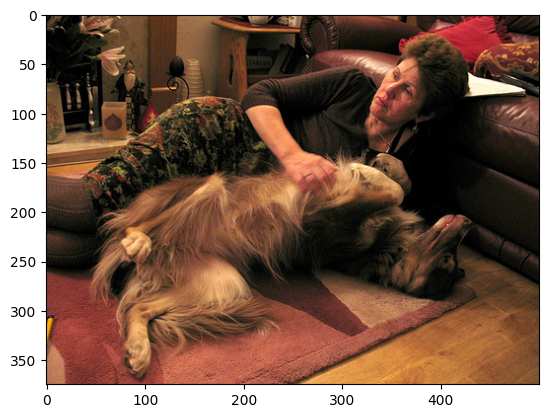

In [63]:
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

sampled_dataset = GQADataset("../data/questions/train_sampled_questions_10000.json", "../data/images/")

img = 8

plt.imshow(sampled_dataset[img][0].permute(1, 2, 0))

inputs = blip_processor(sampled_dataset[img][0], "a dog", return_tensors="pt").to("mps")
itm_scores = blip_model(**inputs)[0]
cosine_score = blip_model(**inputs, use_itm_head=False)[0]
print(inputs['pixel_values'].shape)
print(itm_scores)
print(softmax(itm_scores,dim=1)[:,1])

tensor([[ 1.8575, -1.8486]], grad_fn=<AddmmBackward0>)
tensor([[0.4919]], grad_fn=<MmBackward0>)


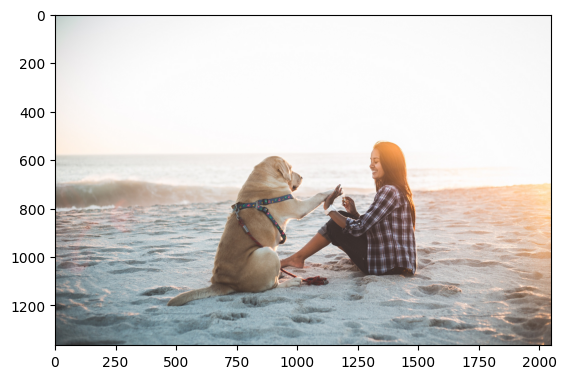

In [76]:
import requests
from PIL import Image

processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
model = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco")

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')

plt.imshow(raw_image)

question = "A woman and a dog sitting together in a beach."
inputs = processor(raw_image, question, return_tensors="pt")

itm_scores = model(**inputs)[0]
cosine_score = model(**inputs, use_itm_head=False)[0]
print(itm_scores)
print(cosine_score)